In [ ]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# PyTorch Image Models
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.0 MB/s eta 0:00:00


In [ ]:
%cd /content/drive/Shareddrives/FYP/Swin-Transformer

/content/drive/Shareddrives/FYP/Swin-Transformer


In [ ]:
# Imports
import PIL
from PIL import Image
import torch
import torch.nn as nn
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import os
from swin_functions_and_classes import *


# Image Classification Using Swin Transformer

Image_resolution = 224 x 224

patch_size = 4 x 4

number of features in one patch = 4 x 4 x 3 = 48

total number of patches in the whole image = 224/4 x 224/4 = 3136

In [ ]:
#Finding image resolution
import PIL
from PIL import Image

# loading the image
img = PIL.Image.open("/content/drive/Shareddrives/FYP/audio_dataset/melspectrogram/fake/FakeVideo-FakeAudio_00001_0_id06152_wavtolip_2137_melspectrogram.png")

# fetching the dimensions
wid, hgt = img.size

# displaying the dimensions
print(str(wid) + "x" + str(hgt))


1000x400


In [ ]:
import torch
import torch.nn as nn
from timm.models.layers import DropPath, to_2tuple, trunc_normal_

In [ ]:
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Load the image file
image_path = '/content/drive/Shareddrives/FYP/audio_dataset/melspectrogram/fake/FakeVideo-FakeAudio_00001_0_id06152_wavtolip_2137_melspectrogram.png'
image = Image.open(image_path)

#CMYK CONVERSION
import cv2
import numpy as np

def cmyk_to_rgb(image):
    # inverted matrix to convert color from CMYK to RGB
    cmyk_to_rgb_matrix = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0]])

    # reshape image from (height, width, 4) to (height*width, 4)
    image = image.reshape(-1, 4)

    # subtract image matrix (height*width, 4) by 255 and then divide it by 255 to normalize data into the range [0, 1]
    normalized_image = np.divide(np.subtract(image, 255), 255).astype(np.float32)

    # apply matrix multiplication to convert color from CMYK to RGB
    rgb_image = np.dot(normalized_image, cmyk_to_rgb_matrix.T).astype(np.uint8)

    # reshape rgb_image from (height*width, 3) to (height, width, 3)
    rgb_image = rgb_image.reshape(image.shape[0], -1, 3)

    return rgb_image

# read the CMYK image using OpenCV
cmyk_image = cv2.imread('/content/drive/Shareddrives/FYP/audio_dataset/melspectrogram/fake/FakeVideo-FakeAudio_00001_0_id06152_wavtolip_2137_melspectrogram.png', cv2.IMREAD_UNCHANGED)

# convert the CMYK image to an RGB image
rgb_image = cmyk_to_rgb(cmyk_image)

# save the RGB image
cv2.imwrite('/content/drive/Shareddrives/FYP/melspectrogram_rgb.png', rgb_image)


# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224
    transforms.ToTensor()  # Convert the image to a tensor
])


# Apply the transformation to the image
tensor_image = transform(image)

# Reshape the tensor to match the expected shape
tensor_image = tensor_image.unsqueeze(0)  # Add batch dimension

# Print the shape and data type of the tensor
print("Tensor shape:", tensor_image.shape)
print("Tensor data type:", tensor_image.dtype)

# Permute dimensions to match the expected shape (B, H, W, C)
tensor_image = tensor_image.permute(0, 2, 3, 1)


Tensor shape: torch.Size([1, 4, 224, 224])
Tensor data type: torch.float32


In [ ]:
def window_partition(x, patch_size=4):
    """
    Args:
        x: (B, H, W, C)
        patch_size (int): patch size (Default: 4)

    Returns:
        patches: (num_patches * B, patch_size, patch_size, C)
                 (num_windows * B, patch_size, patch_size, C)
    """

    B, H, W, C = x.shape

    # Calculate the number of patches in each dimension
    num_patches_h = H // patch_size
    num_patches_w = W // patch_size

    # Convert to (B, num_patches_h, patch_size, num_patches_w, patch_size, C)
    x = x.view(B, num_patches_h, patch_size, num_patches_w, patch_size, C)

    # Convert to (B, num_patches_h, num_patches_w, patch_size, patch_size, C)
    patches = x.permute(0, 1, 3, 2, 4, 5).contiguous()

    # Efficient Batch Computation - Convert to (B * num_patches_h * num_patches_w, patch_size, patch_size, C)
    patches = patches.view(-1, patch_size, patch_size, C)

    return patches


Windows shape: torch.Size([3136, 4, 4, 4])
num_patches  3136


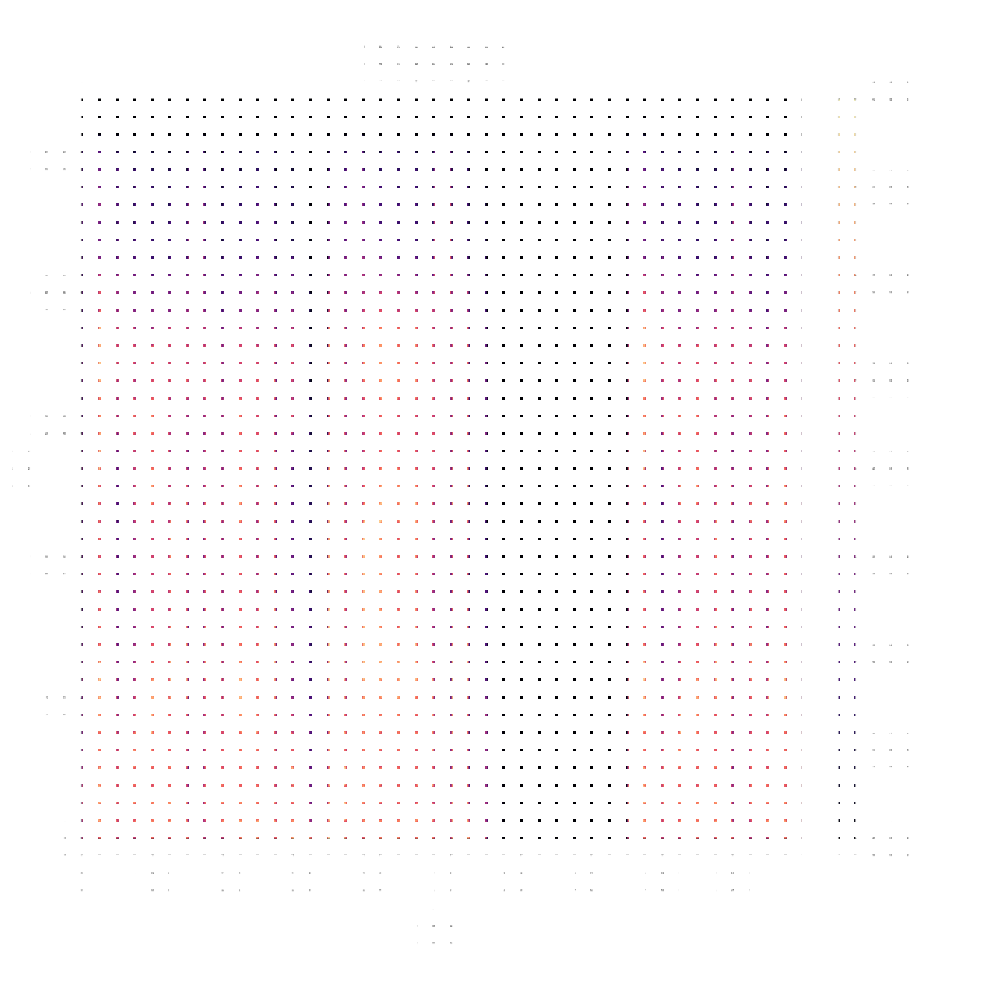

In [ ]:

# Call the window_partition function on the tensor_image
window_size = 4
windows = window_partition(tensor_image, window_size)

num_patches, patch_size, _, _ = windows.shape

# Print the shape of the output windows
print("Windows shape:", windows.shape)

print("num_patches ",num_patches)

# Calculate the number of rows and columns in the grid
num_rows = int(num_patches ** 0.5)
num_cols = num_patches // num_rows

# Create a subplot grid
fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 10))

# Iterate over the patches and plot them
for i, ax in enumerate(axs.flat):
    patch = windows[i].numpy()
    ax.imshow(patch)
    ax.axis("off")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


# (224/4 * 224/4 =56*56 = 3136 patches of size 4*4)

# displaying all the patches (4*4) to visualize properly

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have already obtained the windows tensor

# Iterate over the windows and display them
num_windows = windows.shape[0]
print("Total number of windows:", num_windows)
for i in range(num_windows):
    window = windows[i]  # Get a single window

    # Convert the window tensor to a numpy array and transpose dimensions
    window_np = window.numpy().transpose(1, 0, 2)

    # Normalize the window values to [0, 1] range
    window_np = (window_np - window_np.min()) / (window_np.max() - window_np.min())

    # Display the window image
    plt.imshow(window_np)
    plt.axis('off')
    plt.show()



# Applying Linear Embedding

#### ( 4x4x3 tensor  to 1x1x96 tensor)


In [ ]:
# Lets use PatchEmbed

class PatchEmbed(nn.Module):
    """ Convert image to patch embedding

    Args:
        img_size (int): Image size (Default: 224)
        patch_size (int): Patch token size (Default: 4)
        in_channels (int): Number of input image channels (Default: 3)
        embed_dim (int): Number of linear projection output channels (Default: 96)
        norm_layer (nn.Module, optional): Normalization layer (Default: None)
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size) # (img_size, img_size) to_2tuple simply convert t to (t,t)
        patch_size = to_2tuple(patch_size) # (patch_size, patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]] # (num_patches, num_patches)

        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        # proj layer: (B, 3, 224, 224) -> (B, 96, 56, 56)
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        """
        x: (B, C, H, W) Default: (B, 3, 224, 224)
        returns: (B, H//patch_size * W//patch_size, embed_dim) (B, 56*56, 96)
        """
        B, C, H, W = x.shape
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}]) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."

        # (B, 3, 224, 224) -> (B, 96, 56, 56)
        x = self.proj(x)

        # (B, 96, 56, 56) -> (B, 96, 56*56)
        x = x.flatten(2)

        # (B, 96, 56*56) -> (B, 56*56, 96): 56 refers to the number of patches
        x = x.transpose(1, 2)

        if self.norm is not None:
            x = self.norm(x)

        return x

# Applying patch embedding on  patches

In [ ]:
# Load the image file
image_path = '/content/drive/Shareddrives/FYP/audio_dataset/melspectrogram/fake/FakeVideo-FakeAudio_00001_0_id06152_wavtolip_2137_melspectrogram.png'
image = Image.open(image_path)

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224
    transforms.ToTensor()  # Convert the image to a tensor
])

# Apply the transformation to the image
tensor_image = transform(image)

# Reshape the tensor to match the expected shape
tensor_image = tensor_image.unsqueeze(0)  # Add batch dimension

patch_embed = PatchEmbed(img_size=224, patch_size=4, in_chans=3, embed_dim=96)

embedding = patch_embed(tensor_image)


patches = patch_embed(tensor_image)

# 1st patch embedding vector

In [ ]:
print("First patch embedding vector:", patches[0, 0])

# 96 values in every patch because 96 is embedding dimension we mentioned above

#To access the second patch's embedding vector, you can use patches[0, 1]

First patch embedding vector: tensor([ 0.1975, -0.1677,  0.1375,  0.0485, -0.1009, -0.0177, -0.1350,  0.1713,
        -0.1178, -0.0638, -0.0803, -0.0266, -0.0195, -0.0390,  0.2809,  0.1566,
        -0.1026,  0.2352,  0.2090, -0.1213, -0.0382,  0.2156, -0.1937, -0.1560,
        -0.0935, -0.1721, -0.2792, -0.2036, -0.0942, -0.0195,  0.0545, -0.0669,
         0.0358, -0.0227,  0.0138,  0.0375,  0.1328,  0.2642,  0.0413, -0.0417,
        -0.1304,  0.0279, -0.0617, -0.1760,  0.0129,  0.0732, -0.0291,  0.0015,
         0.0602, -0.0357, -0.2727, -0.1687,  0.1821, -0.0672,  0.1786,  0.1284,
        -0.1911, -0.2640, -0.0527,  0.0112,  0.0024,  0.0247,  0.0878, -0.1171,
        -0.2940, -0.0147,  0.0266, -0.0660, -0.0172,  0.0787, -0.1000,  0.1865,
         0.0712, -0.0832,  0.0457,  0.0060,  0.0140, -0.0839, -0.0736,  0.0018,
        -0.0306, -0.0350,  0.2529,  0.1348,  0.0770, -0.2641, -0.1844, -0.0936,
         0.1987,  0.0133,  0.1977,  0.1053,  0.0741, -0.0696, -0.2928,  0.0714],
       gr

# Using BasicLayer : Swin Transformer layer for one stage

In [ ]:
from swin_functions_and_classes import *

stage_1 = BasicLayer(dim=96, input_resolution=(56, 56), depth=2, num_heads=4, window_size=7)

# Pass the patch embeddings through the BasicLayer
output = stage_1(embedding)

# Patch Merging

##### Using patch merging on the embedding

In [ ]:
# PatchMerging

# Using patch merging on the embedding
merge_layer = PatchMerging(input_resolution=(56, 56), dim=96, norm_layer=nn.LayerNorm)
merged_output = merge_layer(output)
print("Merged output shape:", merged_output.shape)    # (1, 28x28, 96*2) # (1, 784, 192)

Merged output shape: torch.Size([1, 784, 192])


In [ ]:
batch_size = merged_output.shape[0]
num_patches = merged_output.shape[1]
num_channels = merged_output.shape[2]

print("Batch size:", batch_size)
print("Number of patches:", num_patches)
print("Number of channels:", num_channels)

Batch size: 1
Number of patches: 784
Number of channels: 192


the output width and height are both reduced by a factor of 2 and the number of output channels is 2C where C is the number of input channels, here for Swin-T, C=96 .


### Let's create Stage-1 of the Swin-T architecture using SwinTransformerBlock:

Using SwinTransformerBlock class on the patch embedding embedding

In [ ]:
# Create an instance of the SwinTransformerBlock class with the desired parameters
block_1 = SwinTransformerBlock(dim=96, input_resolution=(56, 56), num_heads=4, window_size=7, shift_size=0,
                             mlp_ratio=4.0, qkv_bias=True, qk_scale=None, drop=0.0, attn_drop=0.0,
                             drop_path=0.0, act_layer=nn.GELU, norm_layer=nn.LayerNorm)


#  shift_size is set to 3
block_1_shf = SwinTransformerBlock(dim=96, input_resolution=(56, 56), num_heads=4, window_size=7, shift_size=2,
                             mlp_ratio=4.0, qkv_bias=True, qk_scale=None, drop=0.0, attn_drop=0.0,
                             drop_path=0.0, act_layer=nn.GELU, norm_layer=nn.LayerNorm)


# Pass the embedding through the SwinTransformerBlock:
output = block_1(embedding)
output_shf = block_1_shf(embedding)

print(output.shape)
print(output_shf.shape)
print(output)
print(output_shf)

torch.Size([1, 3136, 96])
torch.Size([1, 3136, 96])
tensor([[[ 0.1504,  0.1148, -0.9033,  ...,  0.0978, -0.7801, -0.2008],
         [ 0.1411,  0.1097, -0.7888,  ...,  0.0655, -0.7323, -0.3246],
         [ 0.0635,  0.0779, -0.8959,  ...,  0.1589, -0.7729, -0.1765],
         ...,
         [ 0.1194, -0.1146, -0.7391,  ...,  0.0918, -0.4939, -0.3880],
         [ 0.0892, -0.1149, -0.7574,  ...,  0.1381, -0.5396, -0.3606],
         [ 0.1661, -0.0649, -0.8302,  ...,  0.1806, -0.7550, -0.3030]]],
       grad_fn=<AddBackward0>)
tensor([[[ 0.1154,  0.4704,  0.0774,  ..., -0.5125, -0.1476,  0.6591],
         [ 0.1332,  0.4650,  0.1885,  ..., -0.5289, -0.0612,  0.5965],
         [-0.0441,  0.4990, -0.0768,  ..., -0.2634, -0.1453,  0.6601],
         ...,
         [ 0.0434,  0.2315,  0.0364,  ..., -0.3468,  0.2313,  0.6218],
         [ 0.0271,  0.2646,  0.0221,  ..., -0.3025,  0.2178,  0.6562],
         [ 0.1464,  0.3783, -0.1250,  ..., -0.2587,  0.1133,  0.6623]]],
       grad_fn=<AddBackward0>)


# SwinTransformer :

In [ ]:
model = SwinTransformer()

print(tensor_image.shape)

model(tensor_image).shape

torch.Size([1, 3, 224, 224])


torch.Size([1, 1000])

a tensor_image tensor  (1, 3, 224, 224), which represents a batch of 1 images with 3 channels and size 224x224.

1000 is the number of classes for the classification head.

torch.Size([1, 1000]) represents the shape of the output tensor when passing tensor_image through the model. In this case, it has a batch size of 1 and 1000 output dimensions, which matches the number of classes specified by num_classes.

### **Custom Dataset**

In [ ]:
# Get the current working directory
current_directory = os.getcwd()

# Paths of Train and Test Mel Spectrogram Images
train_dir = "/content/drive/Shareddrives/FYP/dataset/mel_spectrogram/train"
test_dir = "/content/drive/Shareddrives/FYP/dataset/mel_spectrogram/test"

# Create Datasets and DataLoaders

In [ ]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [ ]:
# Create image size
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [ ]:
# Set the batch size 32
BATCH_SIZE = 8

# Create data loaders
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7d0ff0f5b8b0>,
 ['fake', 'real'])

In [ ]:
model = SwinTransformer(num_classes=len(class_names))

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
from going_modular.going_modular import engine
from helper_functions import set_seeds
import torch

In [ ]:
# Training and Validation
device = "cuda" if torch.cuda.is_available() else "cpu"
device

# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=1e-4, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.01) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds(123)

results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

torch.save(model.state_dict(), "/content/drive/Shareddrives/FYP/trained_model_SWIN_8_1e-4_0.01_5epochs.pth")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0660 | train_acc: 0.9802 | test_loss: 0.0530 | test_acc: 0.9835
Epoch: 2 | train_loss: 0.0650 | train_acc: 0.9808 | test_loss: 0.0437 | test_acc: 0.9852
Epoch: 3 | train_loss: 0.0586 | train_acc: 0.9827 | test_loss: 0.0409 | test_acc: 0.9865
Epoch: 4 | train_loss: 0.0585 | train_acc: 0.9816 | test_loss: 0.0429 | test_acc: 0.9865
Epoch: 5 | train_loss: 0.0567 | train_acc: 0.9827 | test_loss: 0.0373 | test_acc: 0.9893


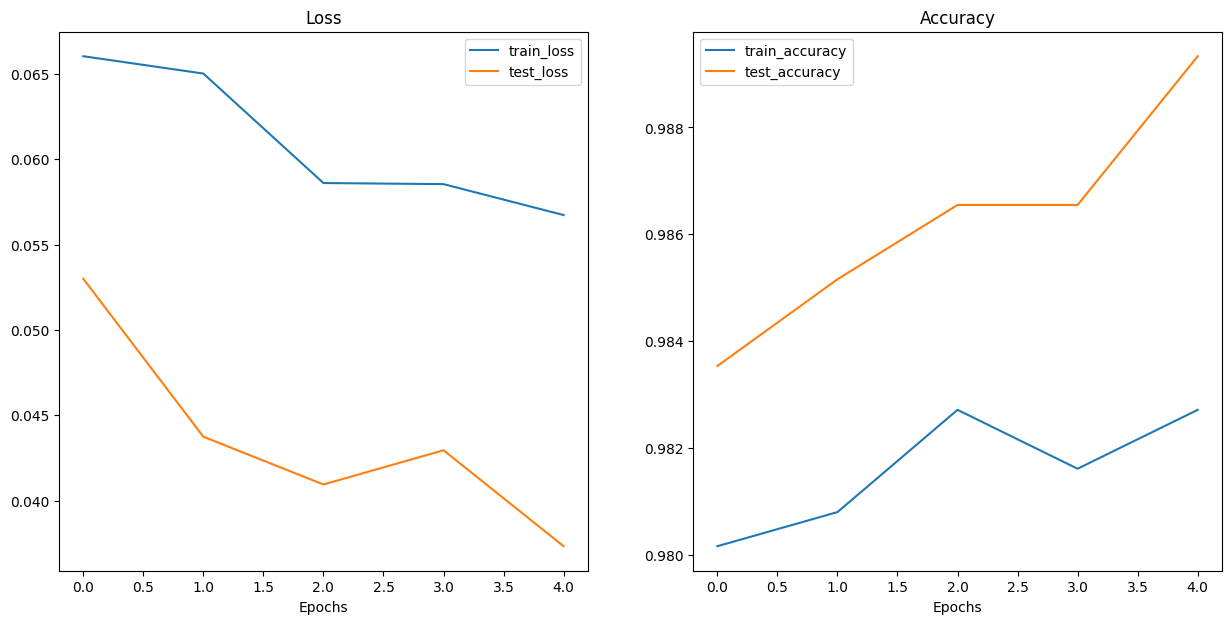

In [ ]:
# To check out our ViT model's loss curves, we can use the plot_loss_curves function from helper_functions.py
from helper_functions import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(results)

# Prediction

In [ ]:
# Load saved model
model.load_state_dict(torch.load('/content/drive/Shareddrives/FYP/trained_model_SWIN_8_1e-4_0.01_5epochs.pth'))
model.eval()

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): ModuleList(
    (0): BasicLayer(
      (blocks): ModuleList(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act_layer): GELU(approximate='none')
            (

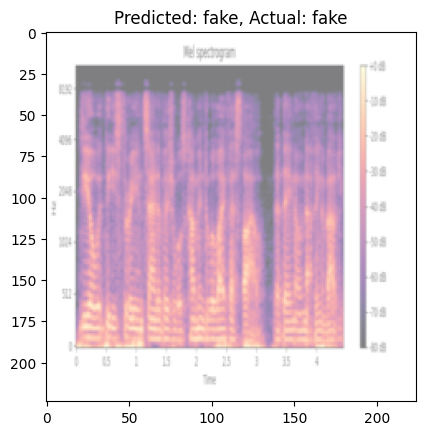

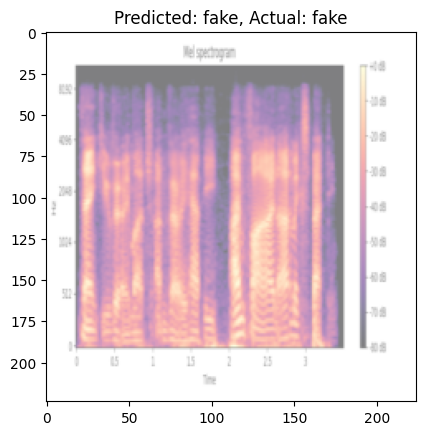

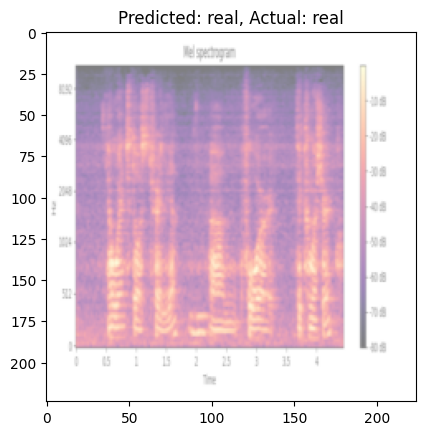

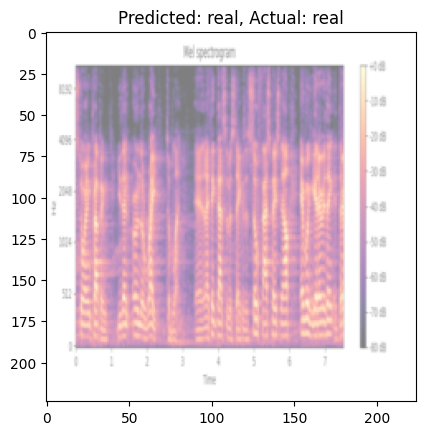

Test Accuracy: 1.0


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model_with_display(model, test_loader, class_names):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Display images and labels
            for i in range(len(labels)):
                image = images[i] / 2 + 0.5  # Unnormalize
                np_image = image.numpy()
                plt.imshow(np.transpose(np_image, (1, 2, 0)))
                plt.title(f'Predicted: {class_names[predicted[i]]}, Actual: {class_names[labels[i]]}')
                plt.show()

    accuracy = correct / total
    return accuracy

# Evaluate the model with display
accuracy = evaluate_model_with_display(model, test_dataloader, class_names)
print("Test Accuracy:", accuracy)
